In [45]:
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
obs = pd.read_excel('combined table fixed.ods', header=1, engine='odf')
obs_model_cols = obs[['COUNTRY', 'LOCATION', 'LATITUDE', 'LONGITUDE', 'Start_date', 'Start_hour', 'End_date', 'End_hour', 'Activity concentration']]

In [47]:
# Clean data, remove those with missing data
obs_model_cols_clean = obs_model_cols.dropna()

# Remove rows with activity concentration below detection limit
obs_model_cols_clean = obs_model_cols_clean[~obs_model_cols_clean['Activity concentration'].astype(str).str.contains('<')]

# Remove Austrian data
obs_model_cols_clean = obs_model_cols_clean[obs_model_cols_clean['COUNTRY'] != 'Austria']

In [48]:
# Combine date and time columns
obs_model_cols_clean.loc[:,'Start date'] = pd.to_datetime(obs_model_cols_clean.Start_date.astype(str)+' '+obs_model_cols_clean.Start_hour.astype(str))
obs_model_cols_clean.loc[:,'End date'] = pd.to_datetime(obs_model_cols_clean.End_date.astype(str)+' '+obs_model_cols_clean.End_hour.astype(str))
obs_model_cols_clean.drop(['Start_date', 'Start_hour', 'End_date', 'End_hour'], axis=1, inplace=True)

In [49]:
# Calculate duration column
obs_model_cols_clean['duration'] = obs_model_cols_clean['End date'] - obs_model_cols_clean['Start date']

# Convert to hours
def convert_to_hours(delta):
    total_seconds = delta.total_seconds()
    hours = str(int(total_seconds // 3600)).zfill(2)
    minutes = str(int((total_seconds % 3600) // 60)).zfill(2)
    seconds = str(int(total_seconds % 60)).zfill(2)
    return f"{hours}:{minutes}:{seconds}"

obs_model_cols_clean["duration"] = obs_model_cols_clean["duration"].apply(convert_to_hours)

In [50]:
cutoff_date = pd.Timestamp("2024-09-27")
obs_model_cols_clean[obs_model_cols_clean['End date'] < cutoff_date]
obs_model_cols_clean[obs_model_cols_clean['End date'] < cutoff_date]['COUNTRY'].value_counts()

COUNTRY
Germany        29
Poland         21
Finland        19
France         16
Switzerland    12
Norway          8
Sweden          8
Italy           2
Estonia         2
Name: count, dtype: int64

In [51]:
obs_model_cols_clean[obs_model_cols_clean['End date'] < cutoff_date].shape

(117, 8)

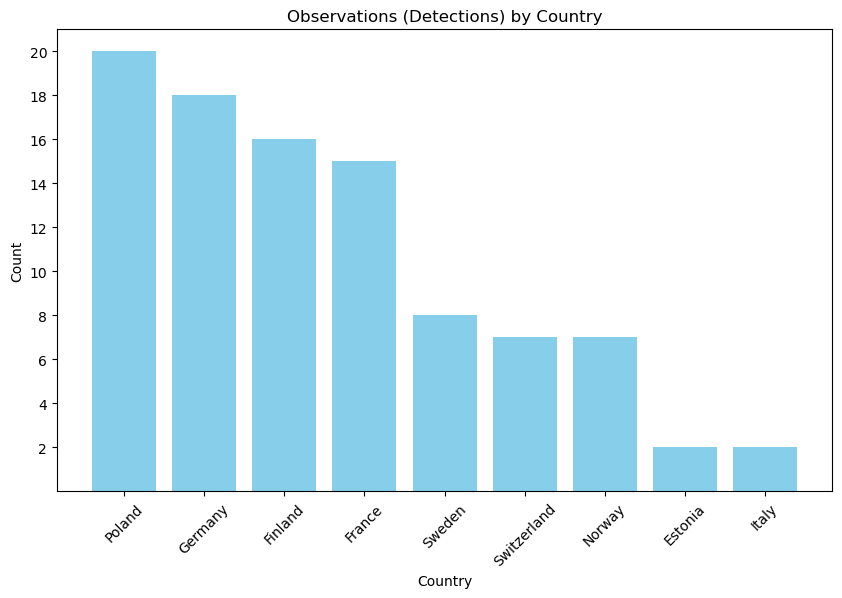

In [52]:
# Get the value counts for "COUNTRY" for dates before the cutoff
# country_counts = obs_model_cols_clean[obs_model_cols_clean['End date'] < cutoff_date]['COUNTRY'].value_counts()

country_counts = {
    "Finland": 16,
    "France": 15,
    "Poland": 20,
    "Germany": 18,
    "Sweden": 8,
    "Switzerland": 7,
    "Norway": 7,
    "Estonia": 2,
    "Italy": 2
}

# Sorting the dictionary by values in descending order
sorted_country_counts = dict(sorted(country_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_country_counts.keys(), sorted_country_counts.values(), color='skyblue')
plt.title("Observations (Detections) by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.yticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.show()


In [53]:
for index, run in obs_model_cols_clean.iterrows():

    with open('snap_template.input', 'r+') as file:
        lines = file.readlines()

    # Edit run title
    location = run.iloc[0]
    startdate = run.iloc[4]
    # if should actually start at the end for inverse run: startdate = run1.iloc[5]
    new_title = 'TITLE=' + location + ' ' + str(startdate) + '\n'
    lines[1] = new_title

    # Edit run location
    lat = run.iloc[1]
    lon = run.iloc[2]
    new_location = 'SET_RELEASE.POS= P=   ' + str(lat) + ',' + '   ' + str(lon) + '\n'
    lines[3] = new_location

    # Edit start date (which is the end date of the observation)
    startdate = run.iloc[5]
    startdate_split = str(startdate).replace(' ', ':').replace('-', ':').split(':')
    new_startdate = 'TIME.START= ' + startdate_split[0] + ' ' + startdate_split[1] + ' ' + startdate_split[2] + ' ' + startdate_split[3] + '\n'
    lines[4] = new_startdate

    # Edit run duration
    duration = run.iloc[6]
    new_duration = 'TIME.RUN = ' + '-' + '1000' + 'h' + '\n'
    lines[5] = new_duration

    # Edit output frequency
    new_frequency = 'STEP.HOUR.OUTPUT.FIELDS = ' + '1' + '\n'
    lines[6] = new_frequency

    # Edit release hour
    new_duration = 'RELEASE.HOUR = ' + '0, ' + str(duration).split(':')[0] + '\n'
    lines[10] = new_duration

    # Edit output file and log names
    output_name = 'FIELD.OUTPUT= ' + '/lustre/storeB/users/chbou7748/chernobyl2024/inverse_runs/output_files_detection/' + location + str(new_startdate[11:-1].replace(' ', '')) + '.nc' + '\n'
    lines[-13] = output_name
    log_name = 'LOG.FILE= ' + '/lustre/storeB/users/chbou7748/chernobyl2024/inverse_runs/output_files_detection/' + location + str(new_startdate[11:-1].replace(' ', '')) + '.log' + '\n'
    lines[-12] = log_name

    with open ('input_files_detection/' + location + str(new_startdate[11:-1].replace(' ', '')) + '.txt', 'w') as file:
        file.writelines(lines)

    file.close()


In [54]:
with open('snap_template.input', 'r+') as file:
    lines = file.readlines()
lines[10]

'RELEASE.HOUR= 0, 48\n'